In [10]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
load_dotenv()

True

In [11]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
llm=HuggingFaceEndpoint(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation"
)
# generator=ChatHuggingFace(llm=llm)


In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI
generator=ChatOpenAI(model='gpt-4o-mini')
evaluator=ChatOpenAI(model='gpt-4o-mini')
optimizer=ChatOpenAI(model='gpt-4o-mini')
# optimizer=ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [13]:
import operator
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal['approved','needs_improvement']
    feedback:str
    iteration:int
    max_iteration:int
    tweet_history:Annotated[list[str],operator.add]
    

In [14]:
def generate_tweet(state: TweetState):
    message = [
        SystemMessage(content="You are generator"),
        HumanMessage(content=f"""
Based on Topic: "{state['topic']}"
Gerate a humorous and crisp tweet 
""")
    ]

    res = optimizer.invoke(message).content

    return {
        "tweet": res,
        "iteration": state["iteration"] + 1,
        "tweet_history": [res]
    }


In [15]:
from pydantic import BaseModel, Field

class TweetEval(BaseModel):
    evaluation:Annotated[Literal['approved','needs_improvement'],Field(description="Final evalution of tweet")]
    feedback:Annotated[str,Field(description="less than 50 word feedback of tweet")]


def evaluate_tweet(state:TweetState):
    messages = [
    SystemMessage(content="You are an expert social media analyst specializing in evaluating tweets objectively."),
    HumanMessage(content=f"""
Evaluate the following tweet based on these factors:

1. Sentiment (Positive, Negative, Neutral)
2. Toxicity (Low, Medium, High)
3. Clarity (Clear or Unclear)
4. Engagement Potential (Low, Medium, High)
5. Presence of Hate Speech or Abusive Language (Yes or No)
6. Overall Quality Score (1–5)

Tweet:
{state['tweet']}

"""
)
]
    structured_model=evaluator.with_structured_output(TweetEval)

    result=structured_model.invoke(messages)

    return {
        'evaluation':result.evaluation,
        'feedback':result.feedback
    }
    



In [16]:
def optimize_tweet(state:TweetState):
    message=[
        SystemMessage(content="You are a tweet optimizer"),
        HumanMessage(content=f"""
Based on Topic: "{state['topic']}, feedback: {state['feedback']} improve this tweet:{state['tweet']}, Give a better tweet"
""")
    ]

    res=optimizer.invoke(message).content
    iteration=state['iteration']+1


    return {
        'tweet':res,
        'iteration':iteration,
        'tweet_history':[res]
    }

In [17]:
def route_evaluation(state:TweetState):
    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

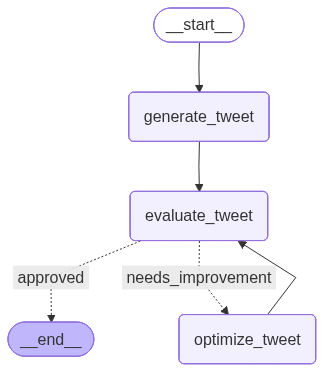

In [18]:
graph=StateGraph(TweetState)

graph.add_node('generate_tweet',generate_tweet)
graph.add_node('evaluate_tweet',evaluate_tweet)
graph.add_node('optimize_tweet',optimize_tweet)


graph.add_edge(START, "generate_tweet")
graph.add_edge('generate_tweet','evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet',route_evaluation,{"approved":END,'needs_improvement':'optimize_tweet'})
graph.add_edge('optimize_tweet','evaluate_tweet')

workflow=graph.compile()

workflow



In [19]:
initial_state={
    'topic':"Large Language Models",
    "iteration":0,
    "max_iteration":3,
    "tweet_history": []
}

In [20]:
final_state=workflow.invoke(initial_state)


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
print(final_state)

{'topic': 'Large Language Models', 'tweet': '"Large Language Models are just like those spaghetti monsters at a linguini convention – they twirl words around so fast, you forget if you wanted a sentence or a meatball! 🍝🤖 #NoodlyNonsense"', 'evaluation': 'approved', 'feedback': 'The tweet uses humor and a creative analogy to describe Large Language Models, making it engaging and clear. The sentiment is positive, and it invites interaction with a playful tone. However, some may find it slightly unconventional.', 'iteration': 0, 'max_iteration': 3, 'tweet_history': ['"Large Language Models are just like those spaghetti monsters at a linguini convention – they twirl words around so fast, you forget if you wanted a sentence or a meatball! 🍝🤖 #NoodlyNonsense"']}


In [ ]:
print(len(final_state['tweet_history']))

1
